In [1]:
import types
import matplotlib.pyplot as plt

# mxnet imports
import mxnet as     mx
from   mxnet import nd
from   mxnet import autograd
from mxnet.gluon.nn.basic_layers import Activation

# standalone lrp imports
import numpy as np
na = np.newaxis
from mxmodules import Sequential, Linear, Rect, Tanh
import model_io, data_io

## Load Patched Functions

In [2]:
from mxlrp import dense_hybrid_forward_lrp

def patch_lrp_gradient_dense(net):
    for layer in net._children:
        if layer.__class__.__name__ == 'Dense':
            layer.hybrid_forward = types.MethodType(dense_hybrid_forward_lrp, layer)

## Define Context

In [3]:
ctx = mx.cpu()

## a) Dummy Network

### 1. Model definition

In [4]:
## ######### ##
# GLUON MODEL #
## ######### ##

net_gl = mx.gluon.nn.HybridSequential()

dense_0 = mx.gluon.nn.Dense(units=12, in_units=4, activation='tanh')
dense_1 = mx.gluon.nn.Dense(units= 1, in_units=12)

net_gl.add(dense_0)
net_gl.add(dense_1)

net_gl.collect_params().initialize(ctx=ctx)

# extract variables from gluon model
weight_0 = dense_0.weight.data()
bias_0   = dense_0.bias.data()

weight_1 = dense_1.weight.data()
bias_1   = dense_1.bias.data()

## ############## ##
# STANDALONE MODEL #
## ############## ##

net_sta = Sequential([Linear(4, 12), Tanh(), Linear(12, 1)])

net_sta.modules[0].W = weight_0.T
net_sta.modules[0].B = bias_0
net_sta.modules[2].W = weight_1.T
net_sta.modules[2].B = bias_1

### 2. Patch gluon gradient to LRP

In [5]:
patch_lrp_gradient_dense(net_gl)

### 3. Comparison with standalone implementation

In [6]:
# forward and backward pass test
X = nd.arange(12).reshape((3, 4))

print('Input:')
print(X)

X.attach_grad()
with autograd.record():
    dense_out = net_gl(X)

dense_out.backward(dense_out)
hm_gluon = X.grad
    
print('\nGLUON impl:')
print(dense_out)
print(hm_gluon)

print('\nStandalone impl:')
linear_out = net_sta.forward(X)
hm_standalone  = net_sta.lrp(linear_out)
print(linear_out)
print(hm_standalone)

Input:

[[  0.   1.   2.   3.]
 [  4.   5.   6.   7.]
 [  8.   9.  10.  11.]]
<NDArray 3x4 @cpu(0)>

GLUON impl:

[[-0.00355378]
 [-0.02960501]
 [-0.048284  ]]
<NDArray 3x1 @cpu(0)>

[[ 0.          0.00364889 -0.00259847 -0.0046042 ]
 [-0.03007531  0.01729889 -0.00631801 -0.01051059]
 [-0.05498287  0.02882986 -0.00622151 -0.01590948]]
<NDArray 3x4 @cpu(0)>

Standalone impl:

[[-0.00355378]
 [-0.02960501]
 [-0.048284  ]]
<NDArray 3x1 @cpu(0)>

[[ 0.          0.00364889 -0.00259847 -0.0046042 ]
 [-0.03007531  0.01729889 -0.00631801 -0.01051059]
 [-0.05498287  0.02882986 -0.00622151 -0.01590948]]
<NDArray 3x4 @cpu(0)>


## b) Long-rect

### 1. Model Definition

In [7]:
## ############## ##
# STANDALONE MODEL #
## ############## ##

long_rect_sta = model_io.read('../models/MNIST/long-rect.nn') # 99.17% prediction accuracy

# remove softmax layer for simplicity
# TODO: add softmax layer treatment and remove this part
long_rect_sta.modules = long_rect_sta.modules[:-1]

loading pickled model from ../models/MNIST/long-rect.nn


In [8]:
## ######### ##
# GLUON MODEL #
## ######### ##
def translate_to_gluon(nn_sta, ctx=mx.cpu()):

    nn_gluon = mx.gluon.nn.HybridSequential()

    print('INPUT NETWORK:\n')
    
    print('-----------------')
    for m_ind, mod in enumerate(nn_sta.modules):

        if m_ind < len(nn_sta.modules) - 1:
            next_module_name = nn_sta.modules[m_ind + 1].__class__.__name__
        else:
            next_module_name = None

        
        print(mod.__class__.__name__)

        if mod.__class__.__name__ == 'Linear':

            if next_module_name == 'Rect':
                activation = 'relu'
            else:
                activation = None

            weight = mod.W
            bias   = mod.B

            print('W : {}'.format(weight.shape))
            print('B : {}'.format(bias.shape))
            print('-----------------')

            # reproduce Linear layer in gluon
            dense = mx.gluon.nn.Dense(units=weight.shape[1], in_units=weight.shape[0], use_bias=True, activation=activation)
            dense.collect_params().initialize(ctx=ctx)
            dense.weight.set_data(weight.T)
            dense.bias.set_data(bias)

            nn_gluon.add(dense)
            
        else:
            print('-----------------')
    
    print('\n\n')
    
    print('OUTPUT NETWORK:')
    print('-----------------')
    print(nn_gluon)
    
    return nn_gluon


long_rect_gluon = translate_to_gluon(long_rect_sta, ctx)

INPUT NETWORK:

-----------------
Linear
W : (784, 1296)
B : (1296,)
-----------------
Rect
-----------------
Linear
W : (1296, 1296)
B : (1296,)
-----------------
Rect
-----------------
Linear
W : (1296, 1296)
B : (1296,)
-----------------
Rect
-----------------
Linear
W : (1296, 10)
B : (10,)
-----------------



OUTPUT NETWORK:
-----------------
HybridSequential(
  (0): Dense(784 -> 1296, Activation(relu))
  (1): Dense(1296 -> 1296, Activation(relu))
  (2): Dense(1296 -> 1296, Activation(relu))
  (3): Dense(1296 -> 10, linear)
)


## 2. Patch Gluon Gradient to LRP

In [9]:
patch_lrp_gradient_dense(long_rect_gluon)

### 3. Compare To Standalone Implementation 

In [10]:
## ######## ##
# LOAD MNIST #
## ######## ##
X = data_io.read('../data/MNIST/test_images.npy')
Y = data_io.read('../data/MNIST/test_labels.npy')

# transfer pixel values from [0 255] to [-1 1] to satisfy the expected input / training paradigm of the model
X =  X / 127.5 - 1

# transform numeric class labels to vector indicator for uniformity. assume presence of all classes within the label set
I = Y[:,0].astype(int)
Y = np.zeros([X.shape[0],np.unique(Y).size])
Y[np.arange(Y.shape[0]),I] = 1

loading np-formatted data from ../data/MNIST/test_images.npy
loading np-formatted data from ../data/MNIST/test_labels.npy


In [11]:
yselect = 3
yselect = (np.arange(Y.shape[1])[na,:] == yselect)*1.
im = X[0][na,:]

im_mx      = nd.array(im,      ctx=ctx)
yselect_mx = nd.array(yselect, ctx=ctx) 

Standalone prediction:
[[ -9.48233082   1.7136009    4.67001061   6.85639303   1.97421727
   -7.90581018 -18.26386241  22.67048759  -1.95408199   2.51839855]]
Gluon prediction:
[[ -9.48233318   1.71360111   4.67001486   6.85639334   1.97421873
   -7.90581036 -18.26386261  22.67048836  -1.95408356   2.51839709]]


Predictions the same: True
Heatmaps    the same: True


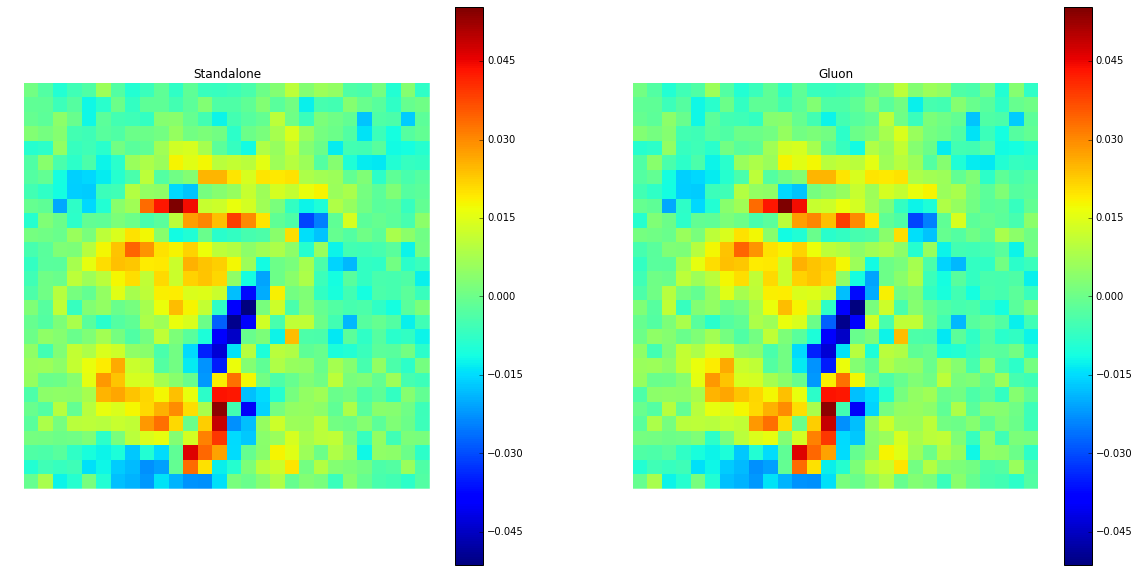

In [25]:
# standalone impl
pred_sta   = long_rect_sta.forward(im)
hm_sta     = long_rect_sta.lrp(yselect)

# gluon impl
im_mx.attach_grad()
with autograd.record():
    pred_gluon = long_rect_gluon(im_mx)
pred_gluon.backward(yselect_mx)

hm_gluon = im_mx.grad

hm_gluon   = hm_gluon.asnumpy()
pred_gluon = pred_gluon.asnumpy()

print('Standalone prediction:')
print(pred_sta)

print('Gluon prediction:')
print(pred_gluon)

print('\n')
print('Predictions the same: {}'.format(np.allclose(pred_sta, pred_gluon)))
print('Heatmaps    the same: {}'.format(np.allclose(hm_sta, hm_gluon)))

fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title('Standalone')
plt.imshow(hm_sta.reshape(28, 28), interpolation='none')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Gluon')
plt.imshow(hm_gluon.reshape(28, 28), interpolation='none')
plt.colorbar()
plt.axis('off')

plt.show()